In [53]:
#!pip install fasttext
#!pip install transformers
#import nltk
#nltk.download('punkt')
#!pip3 install torch torchvision torchaudio

In [1]:
DATA_DIR = "./data/"
VALID_SIZE = .2
MODEL_PATH = "model_task2.bin"

In [2]:
import pandas as pd
import numpy as np
import scipy
import nltk
import re
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.optim import AdamW
from fasttext import load_model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, model_selection
from torch import LongTensor
from sklearn.metrics import f1_score, confusion_matrix, classification_report

---

In [3]:
df = pd.read_csv('../Dataset/data/restaurants_laptop_train_with_pos_task2_cleaned.csv')

In [4]:
df.polarity = df.polarity.replace(-1,2)

encoder = preprocessing.LabelEncoder()
df.loc[:, "aspect_tag"] = encoder.fit_transform(df["aspect_tag"])

sentences = df.groupby("num")["text"].apply(list).values
aspect_tags = df.groupby("num")["aspect_tag"].apply(list).values
polarity_tags = df.groupby("num")["polarity"].apply(list).values

polarity_unique_values = df.polarity.unique()

print('num of aspect tags: {}'.format(len(encoder.classes_)))
print('num of polarity tags: {}'.format(len(polarity_unique_values)))

np.where(encoder.classes_ == "AT")[0].item()

num of aspect tags: 2
num of polarity tags: 4


0

In [5]:
idx = 0
print(sentences[idx])
print(aspect_tags[idx])
print(polarity_tags[idx])

['I', 'charge', 'it', 'at', 'night', 'and', 'skip', 'taking', 'the', 'cord', 'with', 'me', 'because', 'of', 'the', 'good', 'battery', 'life']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]


---

In [11]:
def get_new_aspect_cluster(left, right, aspect_term, polarity, sentence):

    if len(polarity) == 0:
        polarity = 0
    else:
        polarity = int(sum(polarity)/len(polarity))
   
    left.extend(aspect_term)
    left.extend(right)
    return {
        "local_context":left,
        "global_context":sentence,
        "aspect_term":aspect_term,
        "polarity":polarity,
    }

def chop(sentence, aspect_tag, polarity_tag):
    ret_aspect_clusters = []
#     ret_aspect_clusters = {
#         "context":list(),
#         "aspect_term":list(),
#         "polarity":list(),
#     }
    left = []
    right = []
    aspect_term = []
    polarity = []
    doing_left = True
    doing_right = False
    doing_aspect = False
    for i in range(len(sentence)):
        # check if the current token is an aspect term
        if aspect_tag[i] == 0:
            if doing_left:
                doing_aspect = True
                doing_left = False
            elif doing_right:
                doing_right = False
                doing_aspect = True
                # Now, need to save the previous aspect term cluster
                ret_aspect_clusters.append(get_new_aspect_cluster(
                    left, right, aspect_term, polarity, sentence))
                left = right
                right = []
                aspect_term = []
                polarity = []
            aspect_term.append(sentence[i])
            polarity.append(polarity_tag[i])
        else:
            if doing_left:
                left.append(sentence[i])
            elif doing_right:
                right.append(sentence[i])
            else:
                doing_aspect = False
                doing_right = True
                right.append(sentence[i])
                
    ret_aspect_clusters.append(get_new_aspect_cluster(
        left, right, aspect_term, polarity, sentence))
    
    return ret_aspect_clusters

In [12]:
all_aspect_clusters = []
for i in range(len(sentences)):
    all_aspect_clusters.extend(chop(sentences[i], aspect_tags[i], polarity_tags[i]))

In [13]:
# generate word_index list
def build_vocab(df):
    word_idx = {}
    for idx, word in enumerate(sorted(set(df.text.values))):
        word_idx[word] = idx + 1
    return word_idx

def gen_np_embedding(fn, word_idx, dim=100, emb=False):
    if emb:
        model = load_model(fn + ".bin")
    embedding = np.zeros((len(word_idx) + 2, dim))

    with open(fn, encoding="utf8") as f:
        for l in f:
            # for each line, get the word and its vector
            rec = l.rstrip().split(' ')
            if len(rec) == 2:  # skip the first line.
                continue
                # if the word in word_idx, fill the embedding
            if rec[0] in word_idx:
                embedding[word_idx[rec[0]]] = np.array([float(r) for r in rec[1:]])
    for w in word_idx:
        if embedding[word_idx[w]].sum() == 0.:
            if emb:
                embedding[word_idx[w]] = model.get_word_vector(w)
    return embedding

def create_train_data_restaurant(all_aspect_clusters,  word_idx, sent_len=83):

    train_X_local = np.zeros((len(all_aspect_clusters), sent_len), np.int16)
    train_X_global = np.zeros((len(all_aspect_clusters), sent_len), np.int16)

    train_y = np.zeros(len(all_aspect_clusters), np.int16)

    # iterate the asoect
    for sx, sent in enumerate(all_aspect_clusters):
        train_y[sx] = sent['polarity']
        global_sentence = sent['global_context']
        local_sentence = sent['local_context']
        # write word index and tag in train_X
        try:
            for wx, word in enumerate(global_sentence):
                train_X_global[sx, wx] = word_idx[word]

            for wx, word in enumerate(local_sentence):
                train_X_local[sx, wx] = word_idx[word]

        except KeyError:
            continue

    return train_X_local, train_X_global, train_y


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, dict):
        for k, v in data.items():
            data[k] = v.to(device)
        return data
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


def loss_fn(pred, label, num_label):
    pred = pred.view(-1,num_label)
    label = label.view(-1)
    loss = torch.nn.functional.cross_entropy(pred, label)
    return loss


def cal_acc(pred_tags, true_tags):
    if isinstance(pred_tags, list):
        pred_tags = torch.cat(pred_tags, 0)
        true_tags = torch.cat(true_tags, 0)
    acc = (pred_tags == true_tags).sum() / pred_tags.numel()
    f1 = f1_score(true_tags.cpu().numpy(), pred_tags.cpu().numpy(), labels=[0, 1, 2], average='weighted')
    cm = confusion_matrix(true_tags.cpu().numpy(), pred_tags.cpu().numpy())
    return acc, f1, cm


class Model(torch.nn.Module):
    def __init__(self, gen_emb, num_classes=3, alpha = 0.6):
        super(Model, self).__init__()
  
        self.embed = nn.Embedding.from_pretrained(torch.tensor(gen_emb, dtype=torch.float))

        self.lstm = nn.LSTM(gen_emb.shape[1], hidden_size=150, num_layers=1, bidirectional=True, batch_first=True)
        self.dense = nn.Linear(150*2, num_classes)

        self.alpha = alpha
        self.dropout = nn.Dropout(0.3)


    def forward(self, x_train_local, x_train_global):
        x_local = self.embed(x_train_local)
        
        local_seq_lengths = np.sum(np.array(x_train_local) !=0, axis=1)
   
        x_emb_l = torch.nn.utils.rnn.pack_padded_sequence(x_local, local_seq_lengths, batch_first=True, enforce_sorted=False)

        _, (h_n, _) = self.lstm(x_emb_l.float())

        h_n = torch.cat([h_n[-2,:,:], h_n[-1,:,:]], dim=1)

        x_global = self.embed(x_train_global)


        global_seq_lengths = np.sum(np.array(x_train_global) !=0, axis=1)

        x_emb_g = torch.nn.utils.rnn.pack_padded_sequence(x_global, global_seq_lengths, batch_first=True, enforce_sorted=False)

        _, (h_n_g,_) = self.lstm(x_emb_g.float())

        h_n_g = torch.cat([h_n_g[-2,:,:], h_n_g[-1,:,:]], dim=1)

        avg_pool = torch.div(torch.add(h_n * (1 - self.alpha), h_n_g * self.alpha), 2)
        out = self.dropout(avg_pool)

        out = self.dense(out)

        out = torch.nn.functional.log_softmax(out)

        return out

In [14]:
word_indx = build_vocab(df)
    
fn = DATA_DIR + 'glove.840B.300d.txt'
general_embedding = gen_np_embedding(fn, word_indx, dim=300, emb=False)

In [15]:
local_context, global_context, y = create_train_data_restaurant(all_aspect_clusters ,word_indx, sent_len=85)

X_l_train, X_l_valid, X_g_train, X_g_valid,  y_train, y_valid = train_test_split(local_context, global_context, y, test_size=VALID_SIZE)


In [16]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_POLARITY_TAGS = 3

history = {
    "train_loss": list(),
    "polarity_train_acc": list(),
    "valid_loss": list(),
    "polarity_valid_acc": list(),
}

best_loss = np.inf

dataset = TensorDataset(torch.Tensor(X_l_train), torch.Tensor(X_g_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_l_valid),  torch.Tensor(X_g_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding,  num_classes=3, alpha = 0), device)

train samples:4641
valid samples:1161


In [17]:
print(model)

Model(
  (embed): Embedding(6395, 300)
  (lstm): LSTM(300, 150, batch_first=True, bidirectional=True)
  (dense): Linear(in_features=300, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


## Alpha = 0

In [64]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_POLARITY_TAGS = 3

history = {
    "train_loss": list(),
    "polarity_train_acc": list(),
    "valid_loss": list(),
    "polarity_valid_acc": list(),
}

best_loss = np.inf

dataset = TensorDataset(torch.Tensor(X_l_train), torch.Tensor(X_g_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_l_valid),  torch.Tensor(X_g_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding,  num_classes=3, alpha = 0), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        l_feature, g_feature, label = data
        l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()

        optimizer.zero_grad()
        pred_logits = model(l_feature, g_feature)
        loss = loss_fn(pred_logits, label, 3)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds,labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)
            loss = loss_fn(pred_logits, label, 3)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds,  labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['polarity_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['polarity_valid_acc'].append(avg_test_acc.cpu().numpy())
        
    


train samples:4641
valid samples:1161


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.54it/s]



epoch 0
	train_loss:1.063 valid_loss:1.031
	train_acc:51.54% valid_acc:52.54%
	train_f1:0.362 valid_f1:0.363
	train_confusion_matrix:
[[  12  874    1]
 [  53 2362    3]
 [  18 1284    1]]
	valid_confusion_matrix:
[[  0 225   0]
 [  0 609   0]
 [  0 326   1]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.15it/s]



epoch 1
	train_loss:1.009 valid_loss:0.978
	train_acc:52.67% valid_acc:52.45%
	train_f1:0.364 valid_f1:0.361
	train_confusion_matrix:
[[   0  884    0]
 [   0 2423    0]
 [   0 1297    4]]
	valid_confusion_matrix:
[[  0 225   0]
 [  0 609   0]
 [  0 327   0]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.93it/s]



epoch 2
	train_loss:0.968 valid_loss:0.930
	train_acc:52.65% valid_acc:52.71%
	train_f1:0.366 valid_f1:0.368
	train_confusion_matrix:
[[   0  887    0]
 [   0 2416    2]
 [   0 1293   10]]
	valid_confusion_matrix:
[[  0 224   1]
 [  0 608   1]
 [  0 323   4]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.03it/s]



epoch 3
	train_loss:0.904 valid_loss:0.847
	train_acc:57.18% valid_acc:62.02%
	train_f1:0.469 valid_f1:0.549
	train_confusion_matrix:
[[   0  790   95]
 [   0 2339   79]
 [   0 1009  296]]
	valid_confusion_matrix:
[[  0 126  99]
 [  0 539  70]
 [  0 146 181]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  3.28it/s]



epoch 4
	train_loss:0.845 valid_loss:0.812
	train_acc:61.91% valid_acc:63.14%
	train_f1:0.553 valid_f1:0.561
	train_confusion_matrix:
[[   0  481  406]
 [   0 2050  369]
 [   0  499  803]]
	valid_confusion_matrix:
[[  0 119 106]
 [  0 536  73]
 [  0 130 197]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  3.65it/s]



epoch 5
	train_loss:0.814 valid_loss:0.778
	train_acc:63.67% valid_acc:64.43%
	train_f1:0.570 valid_f1:0.577
	train_confusion_matrix:
[[   0  447  441]
 [   0 2044  373]
 [   0  413  890]]
	valid_confusion_matrix:
[[  0  96 129]
 [  0 529  80]
 [  0 108 219]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  3.91it/s]



epoch 6
	train_loss:0.790 valid_loss:0.764
	train_acc:64.58% valid_acc:65.46%
	train_f1:0.579 valid_f1:0.586
	train_confusion_matrix:
[[   0  454  435]
 [   0 2045  374]
 [   0  369  931]]
	valid_confusion_matrix:
[[  0 103 122]
 [  0 532  77]
 [  0  99 228]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  3.30it/s]



epoch 7
	train_loss:0.772 valid_loss:0.750
	train_acc:65.39% valid_acc:65.20%
	train_f1:0.588 valid_f1:0.586
	train_confusion_matrix:
[[   4  445  439]
 [   7 2053  356]
 [   0  348  956]]
	valid_confusion_matrix:
[[  3 109 113]
 [  0 538  71]
 [  1 110 216]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  3.47it/s]



epoch 8
	train_loss:0.756 valid_loss:0.739
	train_acc:66.86% valid_acc:66.06%
	train_f1:0.607 valid_f1:0.601
	train_confusion_matrix:
[[  23  430  438]
 [  11 2072  329]
 [   2  317  986]]
	valid_confusion_matrix:
[[  6  95 124]
 [  0 523  86]
 [  2  87 238]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  3.32it/s]



epoch 9
	train_loss:0.738 valid_loss:0.726
	train_acc:67.45% valid_acc:67.70%
	train_f1:0.618 valid_f1:0.625
	train_confusion_matrix:
[[  41  435  409]
 [  22 2088  312]
 [  13  309  979]]
	valid_confusion_matrix:
[[ 18 106 101]
 [  5 547  57]
 [  3 103 221]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.92it/s]



epoch 10
	train_loss:0.724 valid_loss:0.719
	train_acc:68.62% valid_acc:67.18%
	train_f1:0.640 valid_f1:0.627
	train_confusion_matrix:
[[  86  422  377]
 [  36 2094  287]
 [  26  298  982]]
	valid_confusion_matrix:
[[ 23 102 100]
 [  8 534  67]
 [  8  96 223]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.54it/s]



epoch 11
	train_loss:0.710 valid_loss:0.720
	train_acc:69.44% valid_acc:67.44%
	train_f1:0.657 valid_f1:0.636
	train_confusion_matrix:
[[ 126  418  342]
 [  56 2093  269]
 [  42  281  981]]
	valid_confusion_matrix:
[[ 28  94 103]
 [ 12 523  74]
 [ 12  83 232]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.57it/s]



epoch 12
	train_loss:0.699 valid_loss:0.709
	train_acc:69.99% valid_acc:66.93%
	train_f1:0.669 valid_f1:0.634
	train_confusion_matrix:
[[ 156  392  338]
 [  94 2083  245]
 [  58  256  986]]
	valid_confusion_matrix:
[[ 27  79 119]
 [ 13 510  86]
 [ 14  73 240]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.16it/s]



epoch 13
	train_loss:0.692 valid_loss:0.708
	train_acc:70.33% valid_acc:67.70%
	train_f1:0.677 valid_f1:0.644
	train_confusion_matrix:
[[ 183  378  323]
 [  93 2092  238]
 [  82  253  966]]
	valid_confusion_matrix:
[[ 34  83 108]
 [ 15 520  74]
 [ 15  80 232]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.66it/s]



epoch 14
	train_loss:0.684 valid_loss:0.715
	train_acc:70.99% valid_acc:68.13%
	train_f1:0.686 valid_f1:0.660
	train_confusion_matrix:
[[ 207  354  327]
 [  98 2079  239]
 [  78  241  985]]
	valid_confusion_matrix:
[[ 56  89  80]
 [ 30 529  50]
 [ 30  91 206]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.67it/s]



epoch 15
	train_loss:0.677 valid_loss:0.723
	train_acc:71.05% valid_acc:67.53%
	train_f1:0.687 valid_f1:0.646
	train_confusion_matrix:
[[ 207  350  328]
 [ 102 2092  222]
 [  92  240  975]]
	valid_confusion_matrix:
[[ 46 101  78]
 [ 19 541  49]
 [ 28 102 197]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:01<00:00,  1.77it/s]



epoch 16
	train_loss:0.675 valid_loss:0.715
	train_acc:71.12% valid_acc:68.56%
	train_f1:0.689 valid_f1:0.663
	train_confusion_matrix:
[[ 215  348  325]
 [ 109 2079  228]
 [  87  234  983]]
	valid_confusion_matrix:
[[ 57  89  79]
 [ 22 535  52]
 [ 32  91 204]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.33it/s]



epoch 17
	train_loss:0.660 valid_loss:0.706
	train_acc:72.16% valid_acc:68.39%
	train_f1:0.703 valid_f1:0.662
	train_confusion_matrix:
[[ 249  332  305]
 [ 125 2089  206]
 [  97  218  987]]
	valid_confusion_matrix:
[[ 53  80  92]
 [ 24 517  68]
 [ 21  82 224]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.26it/s]



epoch 18
	train_loss:0.653 valid_loss:0.706
	train_acc:72.61% valid_acc:67.27%
	train_f1:0.709 valid_f1:0.655
	train_confusion_matrix:
[[ 265  329  294]
 [ 117 2099  199]
 [ 110  213  982]]
	valid_confusion_matrix:
[[ 53  68 104]
 [ 31 497  81]
 [ 24  72 231]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.49it/s]


epoch 19
	train_loss:0.648 valid_loss:0.710
	train_acc:72.57% valid_acc:67.87%
	train_f1:0.709 valid_f1:0.659
	train_confusion_matrix:
[[ 260  326  297]
 [ 130 2091  197]
 [ 109  205  993]]
	valid_confusion_matrix:
[[ 56  80  89]
 [ 29 517  63]
 [ 24  88 215]]


(0.4, 0.9)

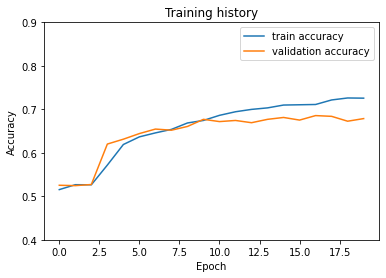

In [65]:
import matplotlib.pyplot as plt
plt.plot(history['polarity_train_acc'], label='train accuracy')
plt.plot(history['polarity_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.4, 0.9])

In [66]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_polarity_tags = []
    final_true_polarity_tags = []


    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)

            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)

            pred_tags = pred_logits.max(-1)[1]

            final_pred_polarity_tags.extend(pred_tags)
            final_true_polarity_tags.extend(label)

    final_pred_polarity_tags = torch.stack(final_pred_polarity_tags).cpu()
    final_true_polarity_tags = torch.stack(final_true_polarity_tags).cpu()
        
    print(classification_report(final_true_polarity_tags, final_pred_polarity_tags, 
                                target_names=["Neutral", "Positive", "Negative"]))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model_task2.bin


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

              precision    recall  f1-score   support

     Neutral       0.54      0.23      0.32       225
    Positive       0.76      0.85      0.80       609
    Negative       0.58      0.68      0.63       327

    accuracy                           0.68      1161
   macro avg       0.63      0.59      0.58      1161
weighted avg       0.67      0.68      0.66      1161



## Alpha = 0.2

In [67]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_POLARITY_TAGS = 3

history = {
    "train_loss": list(),
    "polarity_train_acc": list(),
    "valid_loss": list(),
    "polarity_valid_acc": list(),
}

best_loss = np.inf

dataset = TensorDataset(torch.Tensor(X_l_train), torch.Tensor(X_g_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_l_valid),  torch.Tensor(X_g_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding,  num_classes=3, alpha = 0.2), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        l_feature, g_feature, label = data
        l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()

        optimizer.zero_grad()
        pred_logits = model(l_feature, g_feature)
        loss = loss_fn(pred_logits, label, 3)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds,labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)
            loss = loss_fn(pred_logits, label, 3)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds,  labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['polarity_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['polarity_valid_acc'].append(avg_test_acc.cpu().numpy())
        
    


train samples:4641
valid samples:1161


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.70it/s]



epoch 0
	train_loss:1.065 valid_loss:1.027
	train_acc:50.15% valid_acc:52.45%
	train_f1:0.414 valid_f1:0.361
	train_confusion_matrix:
[[  11  736  138]
 [  13 2075  329]
 [   8 1073  225]]
	valid_confusion_matrix:
[[  0 225   0]
 [  0 609   0]
 [  0 327   0]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:01<00:00,  1.74it/s]



epoch 1
	train_loss:1.006 valid_loss:0.973
	train_acc:52.50% valid_acc:52.54%
	train_f1:0.362 valid_f1:0.363
	train_confusion_matrix:
[[   0  888    0]
 [   0 2417    1]
 [   0 1300    2]]
	valid_confusion_matrix:
[[  0 225   0]
 [  0 609   0]
 [  0 326   1]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.38it/s]



epoch 2
	train_loss:0.965 valid_loss:0.929
	train_acc:52.58% valid_acc:52.54%
	train_f1:0.364 valid_f1:0.364
	train_confusion_matrix:
[[   0  891    0]
 [   0 2415    1]
 [   0 1293    8]]
	valid_confusion_matrix:
[[  0 225   0]
 [  0 608   1]
 [  0 325   2]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.48it/s]



epoch 3
	train_loss:0.901 valid_loss:0.863
	train_acc:55.95% valid_acc:62.45%
	train_f1:0.449 valid_f1:0.550
	train_confusion_matrix:
[[   0  791   96]
 [   0 2343   73]
 [   0 1070  235]]
	valid_confusion_matrix:
[[  0 136  89]
 [  0 553  56]
 [  0 155 172]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.28it/s]



epoch 4
	train_loss:0.842 valid_loss:0.808
	train_acc:62.00% valid_acc:63.74%
	train_f1:0.554 valid_f1:0.572
	train_confusion_matrix:
[[   0  460  428]
 [   0 2045  375]
 [   0  488  812]]
	valid_confusion_matrix:
[[  0  95 130]
 [  0 521  88]
 [  0 108 219]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.06it/s]



epoch 5
	train_loss:0.807 valid_loss:0.773
	train_acc:64.06% valid_acc:64.94%
	train_f1:0.575 valid_f1:0.579
	train_confusion_matrix:
[[   0  417  474]
 [   0 2042  377]
 [   0  388  910]]
	valid_confusion_matrix:
[[  0 103 122]
 [  0 542  67]
 [  0 115 212]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.38it/s]



epoch 6
	train_loss:0.778 valid_loss:0.757
	train_acc:65.26% valid_acc:66.15%
	train_f1:0.586 valid_f1:0.594
	train_confusion_matrix:
[[   0  415  473]
 [   0 2061  357]
 [   0  356  946]]
	valid_confusion_matrix:
[[  0  92 133]
 [  0 529  80]
 [  0  88 239]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.82it/s]



epoch 7
	train_loss:0.759 valid_loss:0.735
	train_acc:66.97% valid_acc:67.18%
	train_f1:0.603 valid_f1:0.603
	train_confusion_matrix:
[[   7  428  456]
 [   1 2094  322]
 [   0  315  985]]
	valid_confusion_matrix:
[[  1  98 126]
 [  0 546  63]
 [  1  93 233]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.78it/s]



epoch 8
	train_loss:0.737 valid_loss:0.719
	train_acc:67.71% valid_acc:68.22%
	train_f1:0.614 valid_f1:0.621
	train_confusion_matrix:
[[  20  424  446]
 [   9 2098  310]
 [   0  299 1002]]
	valid_confusion_matrix:
[[  8  99 118]
 [  2 542  65]
 [  1  84 242]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.35it/s]



epoch 9
	train_loss:0.724 valid_loss:0.740
	train_acc:68.82% valid_acc:68.39%
	train_f1:0.633 valid_f1:0.628
	train_confusion_matrix:
[[  52  418  420]
 [  14 2121  284]
 [  11  290  998]]
	valid_confusion_matrix:
[[ 17 117  91]
 [  1 564  44]
 [  7 107 213]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.51it/s]



epoch 10
	train_loss:0.709 valid_loss:0.701
	train_acc:69.44% valid_acc:68.65%
	train_f1:0.645 valid_f1:0.643
	train_confusion_matrix:
[[  76  397  415]
 [  29 2131  264]
 [  20  283  993]]
	valid_confusion_matrix:
[[ 21  77 127]
 [  9 517  83]
 [  6  62 259]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.92it/s]



epoch 11
	train_loss:0.697 valid_loss:0.695
	train_acc:70.59% valid_acc:69.25%
	train_f1:0.668 valid_f1:0.653
	train_confusion_matrix:
[[ 128  374  385]
 [  60 2126  229]
 [  44  263  999]]
	valid_confusion_matrix:
[[ 26  83 116]
 [ 12 522  75]
 [ 11  60 256]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.96it/s]



epoch 12
	train_loss:0.688 valid_loss:0.684
	train_acc:71.29% valid_acc:69.60%
	train_f1:0.678 valid_f1:0.662
	train_confusion_matrix:
[[ 145  365  381]
 [  64 2113  238]
 [  52  223 1027]]
	valid_confusion_matrix:
[[ 33  87 105]
 [ 17 529  63]
 [ 18  63 246]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.95it/s]



epoch 13
	train_loss:0.682 valid_loss:0.684
	train_acc:71.55% valid_acc:69.51%
	train_f1:0.686 valid_f1:0.667
	train_confusion_matrix:
[[ 173  346  370]
 [  78 2121  218]
 [  55  244 1003]]
	valid_confusion_matrix:
[[ 39  75 111]
 [ 20 518  71]
 [ 20  57 250]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.68it/s]



epoch 14
	train_loss:0.669 valid_loss:0.677
	train_acc:72.20% valid_acc:69.51%
	train_f1:0.697 valid_f1:0.669
	train_confusion_matrix:
[[ 200  344  340]
 [  92 2121  204]
 [  80  221 1006]]
	valid_confusion_matrix:
[[ 39  63 123]
 [ 21 512  76]
 [ 18  53 256]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.97it/s]



epoch 15
	train_loss:0.659 valid_loss:0.706
	train_acc:72.59% valid_acc:68.56%
	train_f1:0.703 valid_f1:0.652
	train_confusion_matrix:
[[ 216  329  342]
 [ 100 2115  203]
 [  83  206 1014]]
	valid_confusion_matrix:
[[ 39 105  81]
 [ 19 550  40]
 [ 27  93 207]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.94it/s]



epoch 16
	train_loss:0.655 valid_loss:0.690
	train_acc:72.66% valid_acc:69.51%
	train_f1:0.705 valid_f1:0.668
	train_confusion_matrix:
[[ 223  317  349]
 [ 106 2113  193]
 [  89  206 1012]]
	valid_confusion_matrix:
[[ 49  88  88]
 [ 19 544  46]
 [ 27  86 214]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.72it/s]



epoch 17
	train_loss:0.647 valid_loss:0.671
	train_acc:73.42% valid_acc:69.85%
	train_f1:0.716 valid_f1:0.677
	train_confusion_matrix:
[[ 257  300  335]
 [ 113 2126  178]
 [ 112  187 1000]]
	valid_confusion_matrix:
[[ 50  73 102]
 [ 24 519  66]
 [ 26  59 242]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.74it/s]



epoch 18
	train_loss:0.639 valid_loss:0.693
	train_acc:73.42% valid_acc:69.16%
	train_f1:0.714 valid_f1:0.671
	train_confusion_matrix:
[[ 239  314  339]
 [ 106 2109  197]
 [  94  175 1035]]
	valid_confusion_matrix:
[[ 57  86  82]
 [ 31 537  41]
 [ 41  77 209]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.61it/s]


epoch 19
	train_loss:0.631 valid_loss:0.673
	train_acc:73.96% valid_acc:69.68%
	train_f1:0.725 valid_f1:0.672
	train_confusion_matrix:
[[ 288  291  311]
 [ 131 2124  160]
 [ 131  176  996]]
	valid_confusion_matrix:
[[ 43  71 111]
 [ 25 519  65]
 [ 23  57 247]]


(0.4, 0.9)

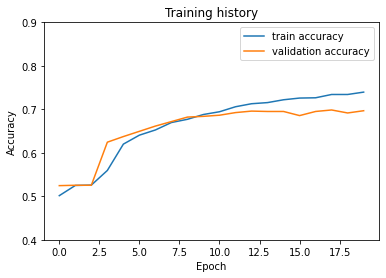

In [68]:
import matplotlib.pyplot as plt
plt.plot(history['polarity_train_acc'], label='train accuracy')
plt.plot(history['polarity_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.4, 0.9])

In [69]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_polarity_tags = []
    final_true_polarity_tags = []


    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)

            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)

            pred_tags = pred_logits.max(-1)[1]

            final_pred_polarity_tags.extend(pred_tags)
            final_true_polarity_tags.extend(label)

    final_pred_polarity_tags = torch.stack(final_pred_polarity_tags).cpu()
    final_true_polarity_tags = torch.stack(final_true_polarity_tags).cpu()
        
    print(classification_report(final_true_polarity_tags, final_pred_polarity_tags, 
                                target_names=["Neutral", "Positive", "Negative"]))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model_task2.bin


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.40it/s]

              precision    recall  f1-score   support

     Neutral       0.47      0.20      0.28       225
    Positive       0.80      0.86      0.83       609
    Negative       0.59      0.74      0.65       327

    accuracy                           0.70      1161
   macro avg       0.62      0.60      0.59      1161
weighted avg       0.67      0.70      0.67      1161



## Alpha = 0.4

In [70]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_POLARITY_TAGS = 3

history = {
    "train_loss": list(),
    "polarity_train_acc": list(),
    "valid_loss": list(),
    "polarity_valid_acc": list(),
}

best_loss = np.inf

dataset = TensorDataset(torch.Tensor(X_l_train), torch.Tensor(X_g_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_l_valid),  torch.Tensor(X_g_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding,  num_classes=3, alpha = 0.4), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        l_feature, g_feature, label = data
        l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()

        optimizer.zero_grad()
        pred_logits = model(l_feature, g_feature)
        loss = loss_fn(pred_logits, label, 3)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds,labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)
            loss = loss_fn(pred_logits, label, 3)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds,  labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['polarity_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['polarity_valid_acc'].append(avg_test_acc.cpu().numpy())
        
    


train samples:4641
valid samples:1161


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.47it/s]



epoch 0
	train_loss:1.067 valid_loss:1.031
	train_acc:50.22% valid_acc:52.63%
	train_f1:0.384 valid_f1:0.365
	train_confusion_matrix:
[[  75  809    3]
 [ 179 2217   22]
 [ 106 1175   22]]
	valid_confusion_matrix:
[[  0 225   0]
 [  0 609   0]
 [  0 325   2]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.44it/s]



epoch 1
	train_loss:1.008 valid_loss:0.970
	train_acc:52.56% valid_acc:52.63%
	train_f1:0.365 valid_f1:0.365
	train_confusion_matrix:
[[   0  892    0]
 [   0 2411    2]
 [   0 1292   11]]
	valid_confusion_matrix:
[[  0 225   0]
 [  0 609   0]
 [  0 325   2]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.23it/s]



epoch 2
	train_loss:0.959 valid_loss:0.913
	train_acc:52.91% valid_acc:53.83%
	train_f1:0.372 valid_f1:0.395
	train_confusion_matrix:
[[   0  886    1]
 [   0 2415    4]
 [   0 1279   23]]
	valid_confusion_matrix:
[[  0 220   5]
 [  0 606   3]
 [  0 308  19]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.13it/s]



epoch 3
	train_loss:0.883 valid_loss:0.837
	train_acc:59.33% valid_acc:63.48%
	train_f1:0.506 valid_f1:0.562
	train_confusion_matrix:
[[   0  684  200]
 [   0 2280  136]
 [   0  854  454]]
	valid_confusion_matrix:
[[  0 131  94]
 [  0 548  61]
 [  0 138 189]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.36it/s]



epoch 4
	train_loss:0.817 valid_loss:0.784
	train_acc:63.65% valid_acc:64.77%
	train_f1:0.570 valid_f1:0.574
	train_confusion_matrix:
[[   0  436  451]
 [   0 2065  355]
 [   0  433  868]]
	valid_confusion_matrix:
[[  0 129  96]
 [  0 556  53]
 [  0 131 196]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.33it/s]



epoch 5
	train_loss:0.792 valid_loss:0.770
	train_acc:65.32% valid_acc:65.98%
	train_f1:0.586 valid_f1:0.594
	train_confusion_matrix:
[[   0  414  472]
 [   0 2073  347]
 [   0  365  937]]
	valid_confusion_matrix:
[[  0  89 136]
 [  0 517  92]
 [  0  78 249]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.35it/s]



epoch 6
	train_loss:0.764 valid_loss:0.745
	train_acc:66.97% valid_acc:66.84%
	train_f1:0.599 valid_f1:0.597
	train_confusion_matrix:
[[   0  440  445]
 [   0 2143  280]
 [   0  357  943]]
	valid_confusion_matrix:
[[  0 114 111]
 [  0 548  61]
 [  1  98 228]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.58it/s]



epoch 7
	train_loss:0.745 valid_loss:0.740
	train_acc:67.73% valid_acc:67.10%
	train_f1:0.611 valid_f1:0.598
	train_confusion_matrix:
[[   9  408  473]
 [   3 2106  304]
 [   1  298 1006]]
	valid_confusion_matrix:
[[  1 125  99]
 [  0 561  48]
 [  1 109 217]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.47it/s]



epoch 8
	train_loss:0.740 valid_loss:0.724
	train_acc:67.86% valid_acc:67.79%
	train_f1:0.615 valid_f1:0.612
	train_confusion_matrix:
[[  16  389  480]
 [   7 2076  333]
 [   2  270 1035]]
	valid_confusion_matrix:
[[  4 101 120]
 [  0 546  63]
 [  3  87 237]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.90it/s]



epoch 9
	train_loss:0.729 valid_loss:0.704
	train_acc:68.64% valid_acc:68.65%
	train_f1:0.632 valid_f1:0.626
	train_confusion_matrix:
[[  53  398  438]
 [  20 2109  288]
 [  11  290 1001]]
	valid_confusion_matrix:
[[  6  85 134]
 [  1 525  83]
 [  1  60 266]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.84it/s]



epoch 10
	train_loss:0.713 valid_loss:0.705
	train_acc:69.25% valid_acc:69.16%
	train_f1:0.639 valid_f1:0.638
	train_confusion_matrix:
[[  58  384  448]
 [  20 2106  291]
 [  10  264 1027]]
	valid_confusion_matrix:
[[ 15  94 116]
 [  2 536  71]
 [  3  72 252]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.26it/s]



epoch 11
	train_loss:0.699 valid_loss:0.695
	train_acc:70.14% valid_acc:69.77%
	train_f1:0.651 valid_f1:0.648
	train_confusion_matrix:
[[  74  395  419]
 [  29 2127  260]
 [  15  258 1031]]
	valid_confusion_matrix:
[[ 20  92 113]
 [  4 537  68]
 [  3  71 253]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.95it/s]



epoch 12
	train_loss:0.686 valid_loss:0.696
	train_acc:71.14% valid_acc:69.34%
	train_f1:0.666 valid_f1:0.652
	train_confusion_matrix:
[[ 101  406  384]
 [  33 2150  234]
 [  25  248 1027]]
	valid_confusion_matrix:
[[ 26  85 114]
 [  9 534  66]
 [  9  73 245]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.62it/s]



epoch 13
	train_loss:0.679 valid_loss:0.692
	train_acc:71.27% valid_acc:69.42%
	train_f1:0.678 valid_f1:0.661
	train_confusion_matrix:
[[ 142  358  387]
 [  57 2116  247]
 [  55  220 1026]]
	valid_confusion_matrix:
[[ 34  81 110]
 [ 19 526  64]
 [ 14  67 246]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.48it/s]



epoch 14
	train_loss:0.670 valid_loss:0.685
	train_acc:71.88% valid_acc:69.51%
	train_f1:0.685 valid_f1:0.661
	train_confusion_matrix:
[[ 155  374  360]
 [  55 2135  225]
 [  53  229 1022]]
	valid_confusion_matrix:
[[ 36  88 101]
 [ 19 531  59]
 [ 12  75 240]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.77it/s]



epoch 15
	train_loss:0.660 valid_loss:0.685
	train_acc:72.44% valid_acc:70.37%
	train_f1:0.695 valid_f1:0.672
	train_confusion_matrix:
[[ 182  363  342]
 [  68 2146  209]
 [  64  224 1010]]
	valid_confusion_matrix:
[[ 41  93  91]
 [ 21 538  50]
 [ 13  76 238]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  3.01it/s]



epoch 16
	train_loss:0.650 valid_loss:0.672
	train_acc:73.09% valid_acc:70.37%
	train_f1:0.707 valid_f1:0.673
	train_confusion_matrix:
[[ 220  332  336]
 [  82 2141  196]
 [  80  214 1007]]
	valid_confusion_matrix:
[[ 40  80 105]
 [ 17 527  65]
 [ 14  63 250]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.58it/s]



epoch 17
	train_loss:0.654 valid_loss:0.693
	train_acc:73.00% valid_acc:69.51%
	train_f1:0.707 valid_f1:0.675
	train_confusion_matrix:
[[ 221  336  332]
 [  79 2127  214]
 [  80  203 1016]]
	valid_confusion_matrix:
[[ 54  72  99]
 [ 30 519  60]
 [ 22  71 234]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.84it/s]



epoch 18
	train_loss:0.645 valid_loss:0.678
	train_acc:73.31% valid_acc:69.77%
	train_f1:0.713 valid_f1:0.676
	train_confusion_matrix:
[[ 233  298  350]
 [ 104 2104  213]
 [  80  185 1041]]
	valid_confusion_matrix:
[[ 56  86  83]
 [ 26 532  51]
 [ 31  74 222]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.88it/s]


epoch 19
	train_loss:0.637 valid_loss:0.671
	train_acc:73.87% valid_acc:70.63%
	train_f1:0.719 valid_f1:0.684
	train_confusion_matrix:
[[ 256  325  305]
 [  90 2144  186]
 [ 100  198 1004]]
	valid_confusion_matrix:
[[ 54  79  92]
 [ 25 528  56]
 [ 20  69 238]]


(0.4, 0.9)

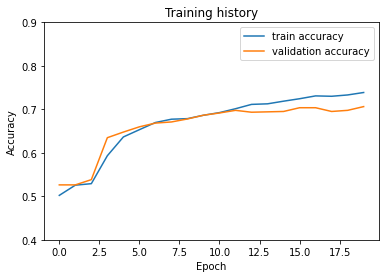

In [71]:
import matplotlib.pyplot as plt
plt.plot(history['polarity_train_acc'], label='train accuracy')
plt.plot(history['polarity_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.4, 0.9])

In [72]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_polarity_tags = []
    final_true_polarity_tags = []


    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)

            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)

            pred_tags = pred_logits.max(-1)[1]

            final_pred_polarity_tags.extend(pred_tags)
            final_true_polarity_tags.extend(label)

    final_pred_polarity_tags = torch.stack(final_pred_polarity_tags).cpu()
    final_true_polarity_tags = torch.stack(final_true_polarity_tags).cpu()
        
    print(classification_report(final_true_polarity_tags, final_pred_polarity_tags, 
                                target_names=["Neutral", "Positive", "Negative"]))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model_task2.bin


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

              precision    recall  f1-score   support

     Neutral       0.52      0.24      0.33       225
    Positive       0.78      0.86      0.82       609
    Negative       0.62      0.72      0.67       327

    accuracy                           0.70      1161
   macro avg       0.64      0.61      0.61      1161
weighted avg       0.68      0.70      0.68      1161



## Alpha = 0.6

In [73]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_POLARITY_TAGS = 3

history = {
    "train_loss": list(),
    "polarity_train_acc": list(),
    "valid_loss": list(),
    "polarity_valid_acc": list(),
}

best_loss = np.inf

dataset = TensorDataset(torch.Tensor(X_l_train), torch.Tensor(X_g_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_l_valid),  torch.Tensor(X_g_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding,  num_classes=3, alpha = 0.6), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        l_feature, g_feature, label = data
        l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()

        optimizer.zero_grad()
        pred_logits = model(l_feature, g_feature)
        loss = loss_fn(pred_logits, label, 3)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds,labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)
            loss = loss_fn(pred_logits, label, 3)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds,  labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['polarity_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['polarity_valid_acc'].append(avg_test_acc.cpu().numpy())
        
    


train samples:4641
valid samples:1161


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.74it/s]



epoch 0
	train_loss:1.067 valid_loss:1.025
	train_acc:46.44% valid_acc:52.71%
	train_f1:0.413 valid_f1:0.367
	train_confusion_matrix:
[[   0  588  295]
 [   1 1673  751]
 [   0  833  467]]
	valid_confusion_matrix:
[[  0 224   1]
 [  0 609   0]
 [  0 324   3]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.72it/s]



epoch 1
	train_loss:1.006 valid_loss:0.970
	train_acc:52.56% valid_acc:52.54%
	train_f1:0.366 valid_f1:0.363
	train_confusion_matrix:
[[   0  889    0]
 [   0 2410    4]
 [   0 1293   12]]
	valid_confusion_matrix:
[[  0 225   0]
 [  0 609   0]
 [  0 326   1]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.77it/s]



epoch 2
	train_loss:0.961 valid_loss:0.919
	train_acc:52.71% valid_acc:52.89%
	train_f1:0.368 valid_f1:0.371
	train_confusion_matrix:
[[   0  887    1]
 [   0 2412    4]
 [   0 1287   17]]
	valid_confusion_matrix:
[[  0 221   4]
 [  0 609   0]
 [  0 322   5]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.77it/s]



epoch 3
	train_loss:0.892 valid_loss:0.845
	train_acc:58.12% valid_acc:63.05%
	train_f1:0.486 valid_f1:0.560
	train_confusion_matrix:
[[   0  721  170]
 [   0 2312  107]
 [   0  932  366]]
	valid_confusion_matrix:
[[  0 116 109]
 [  0 538  71]
 [  0 133 194]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.95it/s]



epoch 4
	train_loss:0.830 valid_loss:0.780
	train_acc:63.76% valid_acc:64.08%
	train_f1:0.571 valid_f1:0.574
	train_confusion_matrix:
[[   0  428  462]
 [   0 2073  344]
 [   0  436  865]]
	valid_confusion_matrix:
[[  0  94 131]
 [  0 527  82]
 [  0 110 217]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.75it/s]



epoch 5
	train_loss:0.792 valid_loss:0.772
	train_acc:65.06% valid_acc:66.24%
	train_f1:0.586 valid_f1:0.600
	train_confusion_matrix:
[[   0  380  507]
 [   0 2034  386]
 [   0  337  964]]
	valid_confusion_matrix:
[[  0  66 159]
 [  0 511  98]
 [  0  69 258]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.11it/s]



epoch 6
	train_loss:0.772 valid_loss:0.742
	train_acc:66.08% valid_acc:67.18%
	train_f1:0.595 valid_f1:0.607
	train_confusion_matrix:
[[   0  374  514]
 [   0 2046  373]
 [   0  302  999]]
	valid_confusion_matrix:
[[  1  83 141]
 [  0 521  88]
 [  0  69 258]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.31it/s]



epoch 7
	train_loss:0.755 valid_loss:0.746
	train_acc:66.91% valid_acc:67.44%
	train_f1:0.603 valid_f1:0.603
	train_confusion_matrix:
[[   5  377  507]
 [   0 2064  354]
 [   0  287 1014]]
	valid_confusion_matrix:
[[  3 116 106]
 [  0 564  45]
 [  0 111 216]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.56it/s]



epoch 8
	train_loss:0.740 valid_loss:0.719
	train_acc:68.36% valid_acc:68.30%
	train_f1:0.621 valid_f1:0.617
	train_confusion_matrix:
[[  22  390  478]
 [   4 2107  304]
 [   2  280 1021]]
	valid_confusion_matrix:
[[  3  97 125]
 [  3 535  71]
 [  1  71 255]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.13it/s]



epoch 9
	train_loss:0.725 valid_loss:0.717
	train_acc:69.16% valid_acc:68.91%
	train_f1:0.631 valid_f1:0.628
	train_confusion_matrix:
[[  32  394  461]
 [  10 2125  283]
 [   3  270 1030]]
	valid_confusion_matrix:
[[  7  89 129]
 [  1 532  76]
 [  1  65 261]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.77it/s]



epoch 10
	train_loss:0.714 valid_loss:0.715
	train_acc:69.42% valid_acc:68.48%
	train_f1:0.637 valid_f1:0.629
	train_confusion_matrix:
[[  48  386  458]
 [   8 2123  283]
 [  11  263 1028]]
	valid_confusion_matrix:
[[ 11  92 122]
 [  5 529  75]
 [  4  68 255]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.12it/s]



epoch 11
	train_loss:0.699 valid_loss:0.702
	train_acc:70.51% valid_acc:69.16%
	train_f1:0.654 valid_f1:0.638
	train_confusion_matrix:
[[  70  373  441]
 [  16 2136  270]
 [  14  245 1043]]
	valid_confusion_matrix:
[[ 15 103 107]
 [  6 541  62]
 [  7  73 247]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.32it/s]



epoch 12
	train_loss:0.689 valid_loss:0.703
	train_acc:70.92% valid_acc:69.16%
	train_f1:0.665 valid_f1:0.643
	train_confusion_matrix:
[[  98  353  438]
 [  29 2126  264]
 [  23  233 1044]]
	valid_confusion_matrix:
[[ 21 109  95]
 [  8 550  51]
 [ 13  82 232]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.80it/s]



epoch 13
	train_loss:0.677 valid_loss:0.689
	train_acc:71.85% valid_acc:70.37%
	train_f1:0.681 valid_f1:0.669
	train_confusion_matrix:
[[ 136  358  392]
 [  40 2147  227]
 [  30  250 1028]]
	valid_confusion_matrix:
[[ 36  86 103]
 [ 11 535  63]
 [ 16  65 246]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.76it/s]



epoch 14
	train_loss:0.667 valid_loss:0.679
	train_acc:72.20% valid_acc:70.46%
	train_f1:0.691 valid_f1:0.669
	train_confusion_matrix:
[[ 170  336  382]
 [  58 2138  225]
 [  61  219 1019]]
	valid_confusion_matrix:
[[ 32  79 114]
 [ 11 528  70]
 [ 14  55 258]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.43it/s]



epoch 15
	train_loss:0.654 valid_loss:0.682
	train_acc:72.74% valid_acc:70.03%
	train_f1:0.701 valid_f1:0.680
	train_confusion_matrix:
[[ 199  316  370]
 [  67 2127  228]
 [  62  213 1026]]
	valid_confusion_matrix:
[[ 53  80  92]
 [ 27 522  60]
 [ 33  56 238]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.39it/s]



epoch 16
	train_loss:0.648 valid_loss:0.688
	train_acc:73.09% valid_acc:69.16%
	train_f1:0.709 valid_f1:0.667
	train_confusion_matrix:
[[ 231  310  350]
 [  88 2118  213]
 [  85  194 1019]]
	valid_confusion_matrix:
[[ 46  89  90]
 [ 24 528  57]
 [ 34  64 229]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.96it/s]



epoch 17
	train_loss:0.638 valid_loss:0.678
	train_acc:73.81% valid_acc:70.28%
	train_f1:0.719 valid_f1:0.681
	train_confusion_matrix:
[[ 253  299  337]
 [  95 2128  193]
 [  93  190 1020]]
	valid_confusion_matrix:
[[ 54  89  82]
 [ 27 536  46]
 [ 33  68 226]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.96it/s]



epoch 18
	train_loss:0.628 valid_loss:0.669
	train_acc:74.46% valid_acc:70.28%
	train_f1:0.727 valid_f1:0.681
	train_confusion_matrix:
[[ 275  298  318]
 [  94 2144  177]
 [ 111  179 1012]]
	valid_confusion_matrix:
[[ 53  81  91]
 [ 28 530  51]
 [ 30  64 233]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.69it/s]


epoch 19
	train_loss:0.617 valid_loss:0.679
	train_acc:74.61% valid_acc:69.68%
	train_f1:0.730 valid_f1:0.677
	train_confusion_matrix:
[[ 282  281  324]
 [  95 2145  177]
 [ 119  174 1011]]
	valid_confusion_matrix:
[[ 53  73  99]
 [ 26 513  70]
 [ 27  57 243]]


(0.4, 0.9)

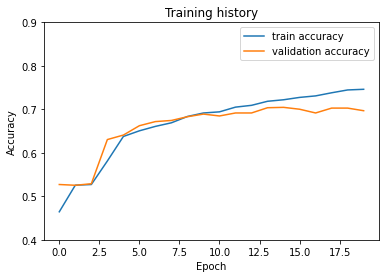

In [74]:
import matplotlib.pyplot as plt
plt.plot(history['polarity_train_acc'], label='train accuracy')
plt.plot(history['polarity_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.4, 0.9])

In [75]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_polarity_tags = []
    final_true_polarity_tags = []


    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)

            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)

            pred_tags = pred_logits.max(-1)[1]

            final_pred_polarity_tags.extend(pred_tags)
            final_true_polarity_tags.extend(label)

    final_pred_polarity_tags = torch.stack(final_pred_polarity_tags).cpu()
    final_true_polarity_tags = torch.stack(final_true_polarity_tags).cpu()
        
    print(classification_report(final_true_polarity_tags, final_pred_polarity_tags, 
                                target_names=["Neutral", "Positive", "Negative"]))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model_task2.bin


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.50it/s]

              precision    recall  f1-score   support

     Neutral       0.49      0.23      0.31       225
    Positive       0.78      0.87      0.82       609
    Negative       0.63      0.72      0.67       327

    accuracy                           0.70      1161
   macro avg       0.63      0.61      0.60      1161
weighted avg       0.68      0.70      0.68      1161



## Alpha = 0.8

In [76]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_POLARITY_TAGS = 3

history = {
    "train_loss": list(),
    "polarity_train_acc": list(),
    "valid_loss": list(),
    "polarity_valid_acc": list(),
}

best_loss = np.inf

dataset = TensorDataset(torch.Tensor(X_l_train), torch.Tensor(X_g_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_l_valid),  torch.Tensor(X_g_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding,  num_classes=3, alpha = 0.8), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        l_feature, g_feature, label = data
        l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()

        optimizer.zero_grad()
        pred_logits = model(l_feature, g_feature)
        loss = loss_fn(pred_logits, label, 3)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds,labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)
            loss = loss_fn(pred_logits, label, 3)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds,  labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['polarity_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['polarity_valid_acc'].append(avg_test_acc.cpu().numpy())
        
    


train samples:4641
valid samples:1161


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.03it/s]



epoch 0
	train_loss:1.064 valid_loss:1.026
	train_acc:49.57% valid_acc:52.54%
	train_f1:0.428 valid_f1:0.364
	train_confusion_matrix:
[[   0  644  243]
 [   1 1903  516]
 [   0  920  381]]
	valid_confusion_matrix:
[[  0 225   0]
 [  0 608   1]
 [  0 325   2]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.73it/s]



epoch 1
	train_loss:1.001 valid_loss:0.964
	train_acc:52.58% valid_acc:52.63%
	train_f1:0.364 valid_f1:0.365
	train_confusion_matrix:
[[   0  891    0]
 [   0 2417    2]
 [   0 1292    6]]
	valid_confusion_matrix:
[[  0 225   0]
 [  0 609   0]
 [  0 325   2]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.39it/s]



epoch 2
	train_loss:0.951 valid_loss:0.904
	train_acc:52.95% valid_acc:53.57%
	train_f1:0.374 valid_f1:0.391
	train_confusion_matrix:
[[   0  887    2]
 [   0 2411    4]
 [   0 1275   29]]
	valid_confusion_matrix:
[[  0 217   8]
 [  0 605   4]
 [  0 310  17]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.67it/s]



epoch 3
	train_loss:0.880 valid_loss:0.839
	train_acc:60.26% valid_acc:63.39%
	train_f1:0.519 valid_f1:0.561
	train_confusion_matrix:
[[   0  663  226]
 [   0 2267  150]
 [   0  792  510]]
	valid_confusion_matrix:
[[  0 128  97]
 [  0 550  59]
 [  0 141 186]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.95it/s]



epoch 4
	train_loss:0.824 valid_loss:0.781
	train_acc:63.98% valid_acc:65.55%
	train_f1:0.572 valid_f1:0.593
	train_confusion_matrix:
[[   0  450  439]
 [   0 2087  331]
 [   0  440  861]]
	valid_confusion_matrix:
[[  0  75 150]
 [  0 505 104]
 [  0  71 256]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.44it/s]



epoch 5
	train_loss:0.788 valid_loss:0.738
	train_acc:65.76% valid_acc:67.53%
	train_f1:0.592 valid_f1:0.605
	train_confusion_matrix:
[[   0  370  518]
 [   0 2033  386]
 [   0  304  997]]
	valid_confusion_matrix:
[[  0  99 126]
 [  0 539  70]
 [  0  82 245]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.68it/s]



epoch 6
	train_loss:0.765 valid_loss:0.723
	train_acc:66.80% valid_acc:67.79%
	train_f1:0.601 valid_f1:0.609
	train_confusion_matrix:
[[   2  396  492]
 [   0 2073  342]
 [   0  300 1003]]
	valid_confusion_matrix:
[[  0  94 131]
 [  0 531  78]
 [  0  71 256]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.98it/s]



epoch 7
	train_loss:0.749 valid_loss:0.713
	train_acc:67.71% valid_acc:68.56%
	train_f1:0.609 valid_f1:0.617
	train_confusion_matrix:
[[   4  406  476]
 [   0 2106  312]
 [   0  294 1010]]
	valid_confusion_matrix:
[[  1  93 131]
 [  0 538  71]
 [  0  70 257]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.75it/s]



epoch 8
	train_loss:0.732 valid_loss:0.700
	train_acc:68.40% valid_acc:69.08%
	train_f1:0.619 valid_f1:0.627
	train_confusion_matrix:
[[  13  390  482]
 [   2 2106  312]
 [   1  269 1033]]
	valid_confusion_matrix:
[[  5  88 132]
 [  0 532  77]
 [  1  61 265]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.99it/s]



epoch 9
	train_loss:0.721 valid_loss:0.696
	train_acc:69.08% valid_acc:69.51%
	train_f1:0.629 valid_f1:0.635
	train_confusion_matrix:
[[  30  386  476]
 [   1 2118  291]
 [   3  268 1035]]
	valid_confusion_matrix:
[[ 12 109 104]
 [  0 549  60]
 [  2  79 246]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.24it/s]



epoch 10
	train_loss:0.709 valid_loss:0.694
	train_acc:70.03% valid_acc:69.51%
	train_f1:0.644 valid_f1:0.638
	train_confusion_matrix:
[[  51  390  447]
 [  11 2160  251]
 [  15  267 1016]]
	valid_confusion_matrix:
[[ 14 109 102]
 [  1 552  56]
 [  4  82 241]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.61it/s]



epoch 11
	train_loss:0.702 valid_loss:0.682
	train_acc:70.23% valid_acc:70.80%
	train_f1:0.652 valid_f1:0.664
	train_confusion_matrix:
[[  73  389  426]
 [  19 2140  259]
 [  30  249 1023]]
	valid_confusion_matrix:
[[ 24  80 121]
 [  5 528  76]
 [  7  50 270]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.55it/s]



epoch 12
	train_loss:0.687 valid_loss:0.678
	train_acc:70.99% valid_acc:70.63%
	train_f1:0.666 valid_f1:0.663
	train_confusion_matrix:
[[  98  366  425]
 [  31 2131  256]
 [  35  224 1042]]
	valid_confusion_matrix:
[[ 25  84 116]
 [  7 527  75]
 [  7  52 268]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.19it/s]



epoch 13
	train_loss:0.679 valid_loss:0.667
	train_acc:71.88% valid_acc:70.89%
	train_f1:0.682 valid_f1:0.672
	train_confusion_matrix:
[[ 139  353  399]
 [  45 2142  233]
 [  48  218 1031]]
	valid_confusion_matrix:
[[ 33  84 108]
 [ 13 534  62]
 [ 12  59 256]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.90it/s]



epoch 14
	train_loss:0.668 valid_loss:0.663
	train_acc:72.70% valid_acc:70.89%
	train_f1:0.695 valid_f1:0.675
	train_confusion_matrix:
[[ 168  338  385]
 [  52 2145  217]
 [  60  206 1037]]
	valid_confusion_matrix:
[[ 35  85 105]
 [ 14 533  62]
 [ 18  54 255]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.19it/s]



epoch 15
	train_loss:0.658 valid_loss:0.666
	train_acc:72.55% valid_acc:70.71%
	train_f1:0.695 valid_f1:0.679
	train_confusion_matrix:
[[ 169  341  376]
 [  67 2145  205]
 [  65  211 1029]]
	valid_confusion_matrix:
[[ 42  78 105]
 [ 17 526  66]
 [ 19  55 253]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.23it/s]



epoch 16
	train_loss:0.649 valid_loss:0.662
	train_acc:73.07% valid_acc:71.06%
	train_f1:0.706 valid_f1:0.679
	train_confusion_matrix:
[[ 211  323  356]
 [  79 2136  201]
 [  85  197 1020]]
	valid_confusion_matrix:
[[ 38  74 113]
 [ 14 524  71]
 [ 14  50 263]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.94it/s]



epoch 17
	train_loss:0.643 valid_loss:0.657
	train_acc:73.48% valid_acc:70.97%
	train_f1:0.713 valid_f1:0.679
	train_confusion_matrix:
[[ 228  314  348]
 [  85 2127  202]
 [  88  185 1031]]
	valid_confusion_matrix:
[[ 39  80 106]
 [ 16 530  63]
 [ 18  54 255]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.27it/s]



epoch 18
	train_loss:0.633 valid_loss:0.651
	train_acc:74.18% valid_acc:70.03%
	train_f1:0.721 valid_f1:0.675
	train_confusion_matrix:
[[ 241  313  332]
 [  85 2134  204]
 [  87  169 1043]]
	valid_confusion_matrix:
[[ 44  73 108]
 [ 25 520  64]
 [ 24  54 249]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


epoch 19
	train_loss:0.624 valid_loss:0.646
	train_acc:74.52% valid_acc:71.15%
	train_f1:0.726 valid_f1:0.685
	train_confusion_matrix:
[[ 251  301  335]
 [  82 2147  187]
 [ 101  168 1036]]
	valid_confusion_matrix:
[[ 45  77 103]
 [ 16 530  63]
 [ 23  53 251]]


(0.4, 0.9)

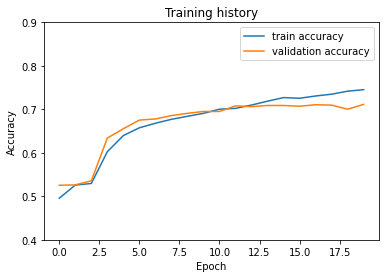

In [77]:
import matplotlib.pyplot as plt
plt.plot(history['polarity_train_acc'], label='train accuracy')
plt.plot(history['polarity_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.4, 0.9])

In [78]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_polarity_tags = []
    final_true_polarity_tags = []


    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)

            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)

            pred_tags = pred_logits.max(-1)[1]

            final_pred_polarity_tags.extend(pred_tags)
            final_true_polarity_tags.extend(label)

    final_pred_polarity_tags = torch.stack(final_pred_polarity_tags).cpu()
    final_true_polarity_tags = torch.stack(final_true_polarity_tags).cpu()
        
    print(classification_report(final_true_polarity_tags, final_pred_polarity_tags, 
                                target_names=["Neutral", "Positive", "Negative"]))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model_task2.bin


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.47it/s]

              precision    recall  f1-score   support

     Neutral       0.49      0.19      0.27       225
    Positive       0.80      0.87      0.83       609
    Negative       0.60      0.76      0.67       327

    accuracy                           0.70      1161
   macro avg       0.63      0.60      0.59      1161
weighted avg       0.68      0.70      0.68      1161



## Alpha = 1

In [79]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_POLARITY_TAGS = 3

history = {
    "train_loss": list(),
    "polarity_train_acc": list(),
    "valid_loss": list(),
    "polarity_valid_acc": list(),
}

best_loss = np.inf

dataset = TensorDataset(torch.Tensor(X_l_train), torch.Tensor(X_g_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_l_valid),  torch.Tensor(X_g_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding,  num_classes=3, alpha = 1), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        l_feature, g_feature, label = data
        l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()

        optimizer.zero_grad()
        pred_logits = model(l_feature, g_feature)
        loss = loss_fn(pred_logits, label, 3)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds,labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)
            loss = loss_fn(pred_logits, label, 3)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds,  labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['polarity_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['polarity_valid_acc'].append(avg_test_acc.cpu().numpy())
        
    


train samples:4641
valid samples:1161


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.33it/s]



epoch 0
	train_loss:1.071 valid_loss:1.031
	train_acc:48.09% valid_acc:52.54%
	train_f1:0.377 valid_f1:0.363
	train_confusion_matrix:
[[  88  782   20]
 [ 266 2100   47]
 [ 119 1158   28]]
	valid_confusion_matrix:
[[  0 225   0]
 [  0 609   0]
 [  0 326   1]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.12it/s]



epoch 1
	train_loss:1.011 valid_loss:0.974
	train_acc:52.50% valid_acc:52.54%
	train_f1:0.363 valid_f1:0.363
	train_confusion_matrix:
[[   0  894    0]
 [   0 2411    0]
 [   0 1295    8]]
	valid_confusion_matrix:
[[  0 225   0]
 [  0 609   0]
 [  0 326   1]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  3.17it/s]



epoch 2
	train_loss:0.968 valid_loss:0.926
	train_acc:52.80% valid_acc:52.71%
	train_f1:0.369 valid_f1:0.368
	train_confusion_matrix:
[[   0  887    0]
 [   0 2418    3]
 [   0 1285   15]]
	valid_confusion_matrix:
[[  0 224   1]
 [  0 608   1]
 [  0 323   4]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.52it/s]



epoch 3
	train_loss:0.911 valid_loss:0.868
	train_acc:56.73% valid_acc:62.19%
	train_f1:0.456 valid_f1:0.539
	train_confusion_matrix:
[[   0  806   85]
 [   0 2367   48]
 [   0 1055  247]]
	valid_confusion_matrix:
[[  0 157  68]
 [  0 578  31]
 [  0 183 144]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.33it/s]



epoch 4
	train_loss:0.848 valid_loss:0.808
	train_acc:62.57% valid_acc:64.25%
	train_f1:0.557 valid_f1:0.580
	train_confusion_matrix:
[[   0  489  399]
 [   0 2101  315]
 [   0  522  782]]
	valid_confusion_matrix:
[[  0  86 139]
 [  0 500 109]
 [  0  81 246]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.62it/s]



epoch 5
	train_loss:0.806 valid_loss:0.771
	train_acc:64.63% valid_acc:65.03%
	train_f1:0.579 valid_f1:0.589
	train_confusion_matrix:
[[   0  412  478]
 [   0 2070  343]
 [   0  397  908]]
	valid_confusion_matrix:
[[  0  74 151]
 [  0 499 110]
 [  0  71 256]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.16it/s]



epoch 6
	train_loss:0.781 valid_loss:0.751
	train_acc:65.89% valid_acc:66.06%
	train_f1:0.594 valid_f1:0.591
	train_confusion_matrix:
[[   4  386  498]
 [   0 2037  379]
 [   0  309  995]]
	valid_confusion_matrix:
[[  1 116 108]
 [  0 539  70]
 [  1  99 227]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.71it/s]



epoch 7
	train_loss:0.763 valid_loss:0.731
	train_acc:67.17% valid_acc:67.61%
	train_f1:0.607 valid_f1:0.609
	train_confusion_matrix:
[[  14  427  449]
 [   1 2087  325]
 [   3  308  994]]
	valid_confusion_matrix:
[[  1 104 120]
 [  1 527  81]
 [  2  68 257]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.83it/s]



epoch 8
	train_loss:0.744 valid_loss:0.733
	train_acc:68.25% valid_acc:67.96%
	train_f1:0.620 valid_f1:0.612
	train_confusion_matrix:
[[  25  405  457]
 [   2 2101  313]
 [   3  283 1019]]
	valid_confusion_matrix:
[[  4 125  96]
 [  4 554  51]
 [  2  94 231]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.28it/s]



epoch 9
	train_loss:0.732 valid_loss:0.728
	train_acc:69.21% valid_acc:68.22%
	train_f1:0.635 valid_f1:0.621
	train_confusion_matrix:
[[  47  411  430]
 [  12 2117  286]
 [   9  271 1025]]
	valid_confusion_matrix:
[[ 11 119  95]
 [  4 556  49]
 [  3  99 225]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.93it/s]



epoch 10
	train_loss:0.715 valid_loss:0.709
	train_acc:69.97% valid_acc:69.51%
	train_f1:0.647 valid_f1:0.647
	train_confusion_matrix:
[[  67  410  409]
 [  16 2149  255]
 [  15  279 1008]]
	valid_confusion_matrix:
[[ 20 104 101]
 [  7 537  65]
 [  9  68 250]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.82it/s]



epoch 11
	train_loss:0.704 valid_loss:0.704
	train_acc:70.86% valid_acc:70.97%
	train_f1:0.666 valid_f1:0.666
	train_confusion_matrix:
[[ 106  385  395]
 [  34 2136  246]
 [  34  249 1023]]
	valid_confusion_matrix:
[[ 28 107  90]
 [  4 551  54]
 [ 13  69 245]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.96it/s]



epoch 12
	train_loss:0.691 valid_loss:0.703
	train_acc:71.35% valid_acc:69.42%
	train_f1:0.677 valid_f1:0.663
	train_confusion_matrix:
[[ 144  377  369]
 [  46 2141  232]
 [  42  254 1003]]
	valid_confusion_matrix:
[[ 35  77 113]
 [ 12 513  84]
 [ 16  53 258]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.60it/s]



epoch 13
	train_loss:0.681 valid_loss:0.695
	train_acc:71.81% valid_acc:71.23%
	train_f1:0.687 valid_f1:0.678
	train_confusion_matrix:
[[ 168  354  365]
 [  55 2109  253]
 [  55  217 1032]]
	valid_confusion_matrix:
[[ 39  98  88]
 [  9 549  51]
 [ 22  66 239]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  2.80it/s]



epoch 14
	train_loss:0.673 valid_loss:0.692
	train_acc:72.48% valid_acc:70.63%
	train_f1:0.698 valid_f1:0.684
	train_confusion_matrix:
[[ 198  336  353]
 [  71 2120  230]
 [  58  220 1022]]
	valid_confusion_matrix:
[[ 51  81  93]
 [ 21 525  63]
 [ 28  55 244]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.58it/s]



epoch 15
	train_loss:0.659 valid_loss:0.687
	train_acc:73.11% valid_acc:70.63%
	train_f1:0.709 valid_f1:0.685
	train_confusion_matrix:
[[ 229  328  329]
 [  94 2129  195]
 [  86  207 1011]]
	valid_confusion_matrix:
[[ 53  79  93]
 [ 22 525  62]
 [ 30  55 242]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.97it/s]



epoch 16
	train_loss:0.654 valid_loss:0.677
	train_acc:73.20% valid_acc:71.06%
	train_f1:0.713 valid_f1:0.684
	train_confusion_matrix:
[[ 254  309  327]
 [ 100 2122  196]
 [  90  213  997]]
	valid_confusion_matrix:
[[ 48  80  97]
 [  8 532  69]
 [ 24  58 245]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.88it/s]



epoch 17
	train_loss:0.644 valid_loss:0.684
	train_acc:73.57% valid_acc:71.49%
	train_f1:0.716 valid_f1:0.694
	train_confusion_matrix:
[[ 251  323  311]
 [  91 2136  192]
 [  83  218 1003]]
	valid_confusion_matrix:
[[ 57  77  91]
 [ 18 527  64]
 [ 27  54 246]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.94it/s]



epoch 18
	train_loss:0.636 valid_loss:0.669
	train_acc:74.13% valid_acc:71.15%
	train_f1:0.725 valid_f1:0.685
	train_confusion_matrix:
[[ 281  300  306]
 [ 112 2122  185]
 [  97  192 1013]]
	valid_confusion_matrix:
[[ 49  83  93]
 [ 12 535  62]
 [ 23  62 242]]


  0%|          | 0/36 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  4.97it/s]


epoch 19
	train_loss:0.628 valid_loss:0.676
	train_acc:74.22% valid_acc:71.40%
	train_f1:0.725 valid_f1:0.687
	train_confusion_matrix:
[[ 267  307  314]
 [ 106 2131  183]
 [  97  181 1022]]
	valid_confusion_matrix:
[[ 48  85  92]
 [ 16 539  54]
 [ 25  60 242]]


(0.4, 0.9)

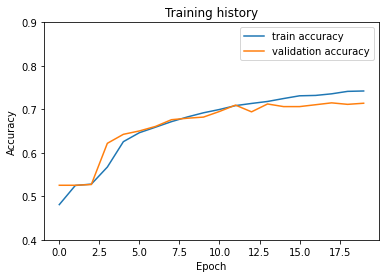

In [80]:
import matplotlib.pyplot as plt
plt.plot(history['polarity_train_acc'], label='train accuracy')
plt.plot(history['polarity_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.4, 0.9])

In [81]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_polarity_tags = []
    final_true_polarity_tags = []


    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)

            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)

            pred_tags = pred_logits.max(-1)[1]

            final_pred_polarity_tags.extend(pred_tags)
            final_true_polarity_tags.extend(label)

    final_pred_polarity_tags = torch.stack(final_pred_polarity_tags).cpu()
    final_true_polarity_tags = torch.stack(final_true_polarity_tags).cpu()
        
    print(classification_report(final_true_polarity_tags, final_pred_polarity_tags, 
                                target_names=["Neutral", "Positive", "Negative"]))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model_task2.bin


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14530/3235636334.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

              precision    recall  f1-score   support

     Neutral       0.57      0.21      0.31       225
    Positive       0.79      0.88      0.83       609
    Negative       0.61      0.75      0.67       327

    accuracy                           0.71      1161
   macro avg       0.66      0.61      0.60      1161
weighted avg       0.70      0.71      0.69      1161

